Author: Gonzalo Marrero Ramallo
Date: 03-05-23

# Package instalation

In [ ]:
pip install pytransit 

In [ ]:
pip install corner

In [ ]:
pip install arviz

In [ ]:
pip install colorcet

In [ ]:
pip install celerite

In [ ]:
pip install emcee

# Radial Velocity analysis of WASP-12b

Universidad de La Laguna Exo & Exo 2023 exercise 1.
Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 17.4.2023

This first exercise teaches you how to estimate the minimum planetary mass from radial velocity measurements using [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).

#(The absolute basics of) radial velocities

A planet orbiting a star causes the star [to move around the star-planet barycentre](https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/#/1). This leads to a periodic change in the star's position and velocity, and the radial component of the star's velocity can be measured using [doppler spectroscopy](https://en.wikipedia.org/wiki/Doppler_spectroscopy). Radial velocity (RV) measurements are used to search for unknown planets and to estimate the minimum masses and orbital periods of known planets.

![Radial Velocity Measurements using Doopler Spectroscopy](https://raw.githubusercontent.com/hpparvi/ull_exoexo_2023/7f7db2871e55a83350aec072e28ba6f8291e2625/Doppler_Shift_vs_Time.svg) 

A planet with a mass $M_P$ orbiting a star with a mass $M_*$ with an orbital period $P$ leads to a periodic signal with a semi-amplitude of:


$$K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_{P}sin(i)}{(M_{*}+M_{P})^{2/3}} \frac{1}{(1-e^{2})^{1/2}}$$ 

where $G$ is the [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant), $e$ is the [orbital eccentricity](https://en.wikipedia.org/wiki/Orbital_eccentricity), and $i$ is the [orbital inclination](https://en.wikipedia.org/wiki/Orbital_inclination). After we estimate $P$, $K$ and $M_*$  and we can solve for the minimum planetary mass $M_P$·$sin(i)$. The orbital period and RV semi-amplitude can be estimated directly from the RV signal, but the stellar mass needs to be estimated using other means.

# (The absolute basics of) Bayesian parameter estimation

Measuring the RV semi-amplitude and the orbital period from RV measurements is a parameter estimation problem: we assume we have an adequate model to describe the observations, and we want to infer the model parameters with their uncertainties.

We take a [Bayesian](https://en.wikipedia.org/wiki/Bayesian_probability) approach to the parameter estimation, where we want to estimate the [posterior probability](https://en.wikipedia.org/wiki/Posterior_probability) for the model parameters given their [prior probabilities](https://en.wikipedia.org/wiki/Prior_probability) and a set of observations. The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the Bayes' theorem as: 

$$P(\theta | D) = \frac{P(\theta) P(D |\theta)}{P(D)}$$ 

$$P(\theta | D) = \prod_{}^{} P(D_{i} | \theta)  $$ 

where $P(\theta)$ is the prior, $P(D |\theta)$ is the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) for the data, $P(D)$ and is a [normalising factor](https://en.wikipedia.org/wiki/Marginal_likelihood) we don't need to bother with during MCMC - based parameter estimation.

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$log P(\theta | D) = log P(\theta) + log P(D |\theta)$$ 

$$log P(\theta | D) = \sum_{}^{} log P(D_{i} | \theta)  $$

where we have omitted the $P(D)$ term from the posterior density.

Now we still need to decide our likelihood density. If we can assume normally distributed white noise--that is, the errors in the observations are independent and identically distributed--we end up with a log likelihood function. 

$$log P(D | \theta) = -N log(\sigma) \frac{N log(2\pi)}{2} - \sum_{i=0}^{N} \frac{(o_{i} - m_{i})^{2}}{2\sigma^{2}}$$ 

where $N$ is the number of datapoints, $\sigma$ is the white noise standard deviation, $o$ is the observed data, and $m$ is the model.
This should be enough for these exercies, but you can find more information from [A primer about Bayesian statistics](https://arxiv.org/pdf/1711.03329.pdf) and the references therein.

# Code

## Initialisation

In [7]:
%matplotlib inline

In [8]:
import pandas as pd
import astropy.units as u
import numpy as np

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, median
from astropy.table import Table
from astropy.timeseries import LombScargle
from corner import corner

from pytransit.lpf.rvlpf import RVLPF

rc('figure', figsize=(13,4))

## 1.1 Read in the RV data 

The radial velocity measurements consist of mid-observation times, radial velocity values, and radial velocity measurement uncertainties (also called as 'errors'). We use the data from [Yee et al. (2019)](https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16). The data is stored as a CDS table that can be read directly using `astropy.table.Table`.

In [9]:
rv_data = Table.read('wasp_12b_yee_2019.dat', format='ascii.cds')

In [10]:
rv_data[:5]

BJD,RVel,e_RVel
d,m / s,m / s
float64,float64,float64
2455521.959432,-136.635,2.534
2455543.089922,5.728,2.919
2455545.983884,-162.39,2.822
2455559.906718,141.616,2.345
2455559.917563,115.818,2.727


It's also useful to visualise directly what we're working with, so we next plot the radial velocity data and its uncertainties as a function of time.

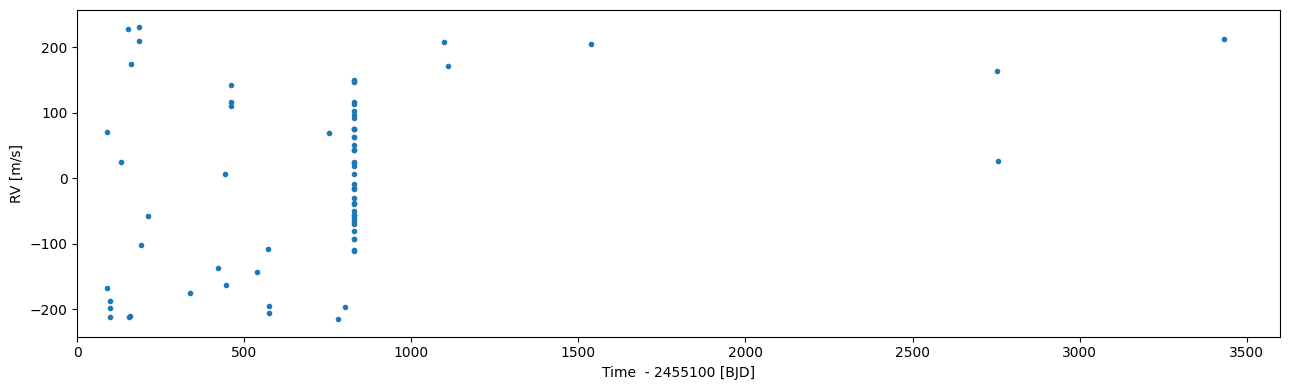

In [11]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(0, 3600))
fig.tight_layout()

### <span style="color:darkblue">Questions and exercises:</span>
Try to describe the logic behind the time sampling of the RV observations.

Plot below the RV observations as a function of time focusing on the densely-sampled time-span.

Answer:
To understand the behaviour of the radial velocity through time, the measurements are in different times, and put into the same moment to understand the phase, as we can see in the plot. The fact of having this wide spread of time sampling is to cover as many error sources as possible.   


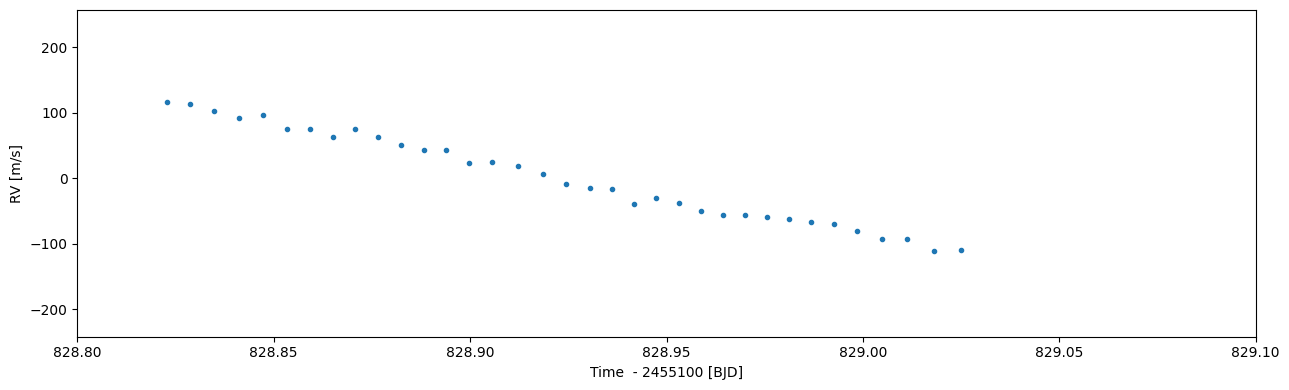

In [12]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(828.8, 829.10)) #We focused on a
fig.tight_layout()

## 1.2 Search for a radial velocity signal

First, we use a Lomb-Scargle periodigram to search for a sinusoidial radial velocity signal from the RV measurements. This is simple to do with `astropy.timeseries.LombScargle` class that is initialised with the mid-measurement times and the RV observations.

In [13]:
ls = LombScargle(rv_data['BJD'], rv_data['RVel'])

In [14]:
frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
period = 1/frequency

In [15]:
best_period = period[argmax(power)]
best_period

<Quantity 1.09144998 d>

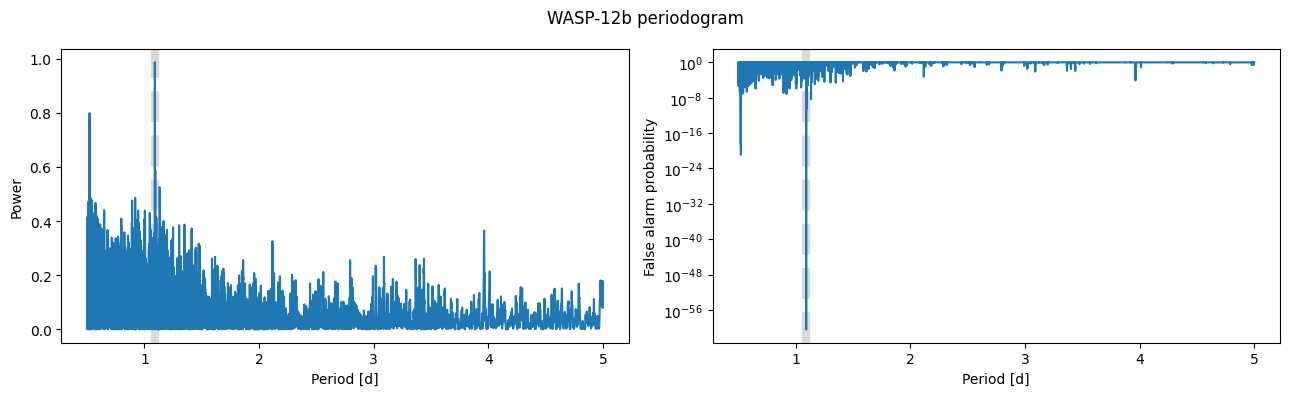

In [16]:
fig, axs = subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[1].semilogy(period, ls.false_alarm_probability(power))
[ax.axvline(best_period.value, c='k', ls='--', zorder=-1, lw=6, alpha=0.15) for ax in axs]
setp(axs, xlabel='Period [d]')
setp(axs[0], ylabel='Power')
setp(axs[1], ylabel='False alarm probability')
fig.suptitle('WASP-12b periodogram')
fig.tight_layout()

Let's see what happens when we plot the RV values folded over the best period.

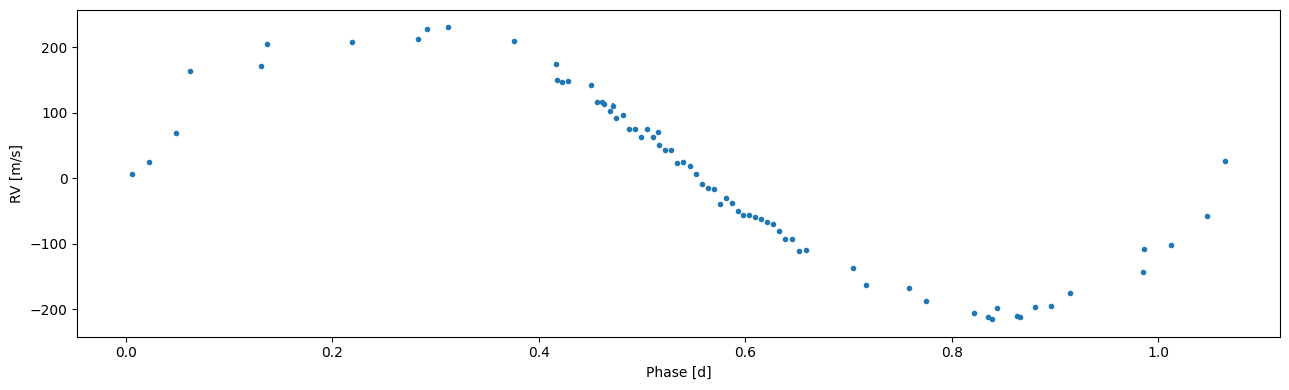

In [17]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] % best_period.value, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

Now when we know the RV data contains a suspicious signal, we can model it to study what sort of an object is causing it. The two most important parameters we're interested are the orbital period and radial velocity semiamplitude (K). The RV semiamplitude will give us the lower limit of the object's mass (
) which will then tell us whether we're dealing with a planet or something else.

## 1.3 Radial velocity modelling

Now when we know the RV data contains a suspicious signal, we can model it to study what sort of an object is causing it. The two most important parameters we're interested are the orbital period and radial velocity semiamplitude (K). The RV semiamplitude will give us the lower limit of the object's mass ($m\sin i$) which will then tell us whether we're dealing with a planet or something else.

### Initialise the model

In [18]:
lpf = RVLPF('WASP-12b', 1, rv_data['BJD'], rv_data['RVel'], rv_data['e_RVel'])

In [19]:
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

The parameters are

- `tc_1`: transit center [BJD]
- `p_1`: orbital period [d]
- `secw_1`: $\sqrt{e} \cos\omega$, where $e$ is the eccentricity and $\omega$ the argument of periastron
- `sesw_1`: $\sqrt{e} \sin\omega$
- `rv_shift_0`: systemic velocity [m/s]
- `rv_err_0`: additional white noise [m/s]
- `rv_k_1` RV semiamplitude [m/s]
- `rv_slope`: additional linear slope

### Set the parameter priors

Bayesian inference requires a prior probability distribution for each of our model parameters. These "priors" can be based on previous studies, theoretical expectations, or more generally in our beliefs on what values the parameters can take.

In this case we use two priors: a normal prior (NP) and a uniform prior (UP). The normal prior models our prior belief using a normal distribution with a known mean and standard deviation, while the uniform prior says that the paramer can take any value between a minimum and maximum boundary.

In [20]:
lpf.set_prior('tc_1', 'NP', 0.0, 1e-5)  # Normal prior (mean, sigma)
lpf.set_prior('p_1', 'NP', 1.09, 0.1)
lpf.set_prior('rv_shift_0', 'NP', 0.0, 10)
lpf.set_prior('rv_err_0', 'UP', 0.0, 30.0) # Uniform prior (min, max)
lpf.set_prior('rv_k_1', 'UP', 0.0, 300)

In [21]:
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 1e-05)                    [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.09, σ = 0.1)                     [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 10.0)                     [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 30.0)                     [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 300)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

### Fit the model to the data

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

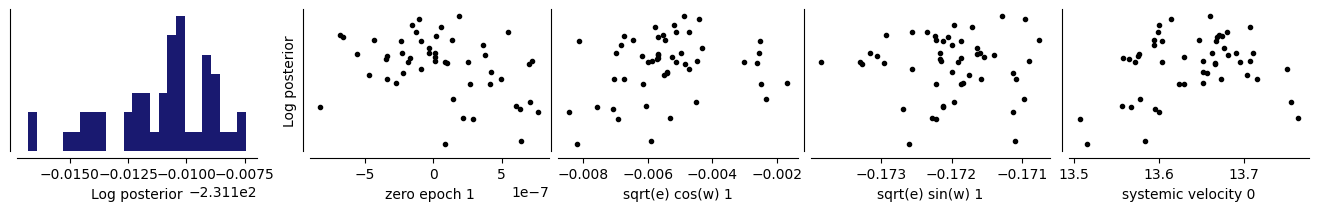

In [22]:
lpf.optimize_global(2000)

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:285: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(self._timea[m] + self._tref, rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


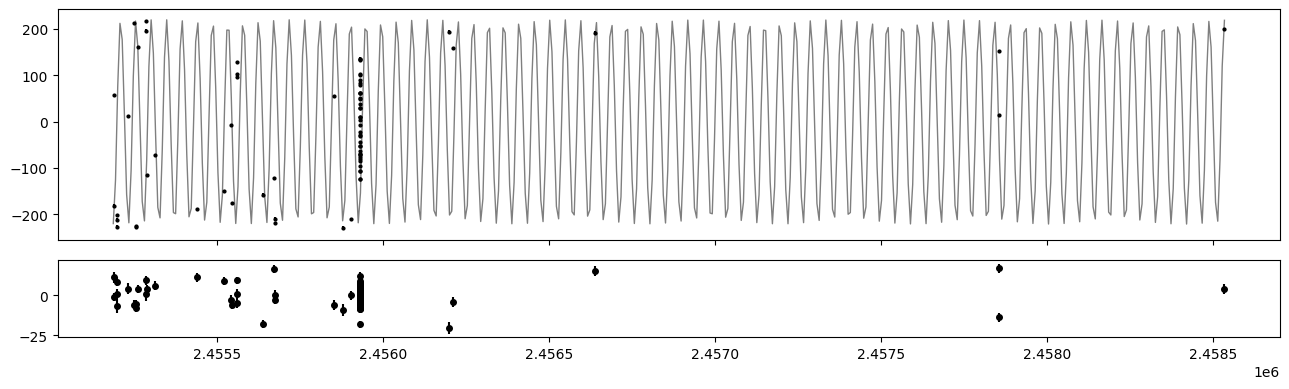

In [23]:
lpf.plot_rv_vs_time();

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:363: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


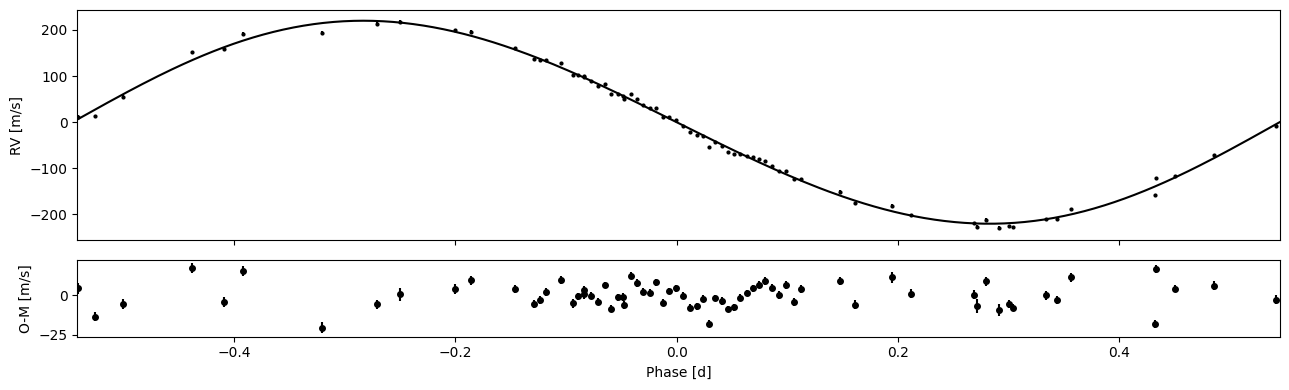

In [24]:
lpf.plot_rv_vs_phase(0);

### Estimate the parameter posterior distributions using MCMC

We estimate the [posterior probability distributions](https://en.wikipedia.org/wiki/Posterior_probability) of our model parameters using [Markov Chain Monte Carlo sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling). The sampling can be done using the `RVLPF.sample_mcmc` method after a global optimisation run has been finished. The `sample_mcmc` method uses the [*emcee*](https://emcee.readthedocs.io/en/stable) sampler under the hood.

We give `RVLPF.sample_mcmc` the number of MCMC steps to take (`niter`), a thinning factor (`thin`), and a number of repeats (`repeats`). This makes the sampler run first one round of `niter` steps, restarts the sampler from the last step of the previous run, and run again `niter` steps. This is the same as running the sampler for `2 x niter` and keeping only the second half of the steps. The first half is treated as a [warm-up period](https://stats.stackexchange.com/questions/88819/mcmc-methods-burning-samples) for the sampler and discarded. In general, the sampler is run `repeats x niter` steps in total, and only the last `niter` steps are retained.

The thinning factor tells the sampler to store only every $n$th step. In our case, we're storing only every 10th step. Thinning is a way to try to store only statistically independent samples, but is [not really necessary](https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/j.2041-210X.2011.00131.x). However, we'll do it to keep the number of samples low (there's no point in storing a large number of dependent samples either).

In [25]:
lpf.sample_mcmc(niter=2000, thin=10, repeats=2)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/2000 [00:00<?, ?it/s]

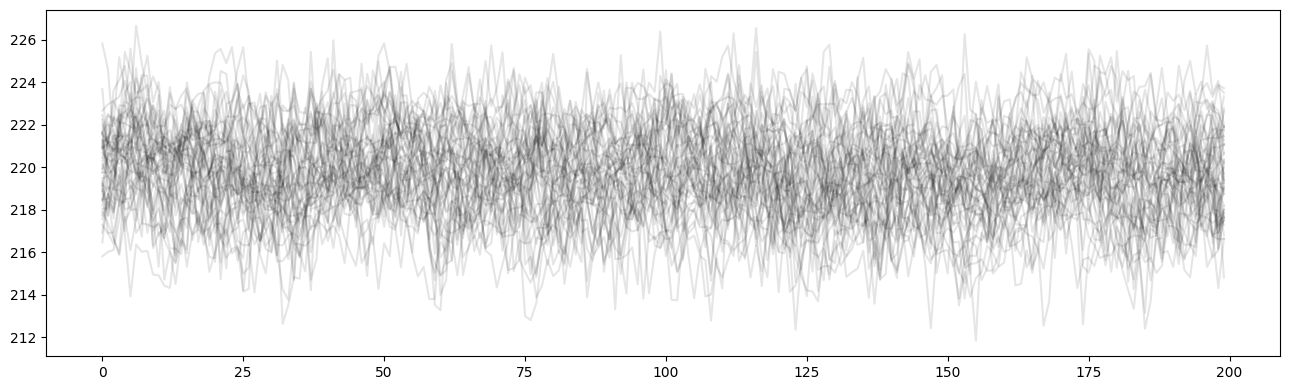

In [26]:
lpf.plot_mcmc_chains(6);

### Plot the model posterior

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:285: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(self._timea[m] + self._tref, rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


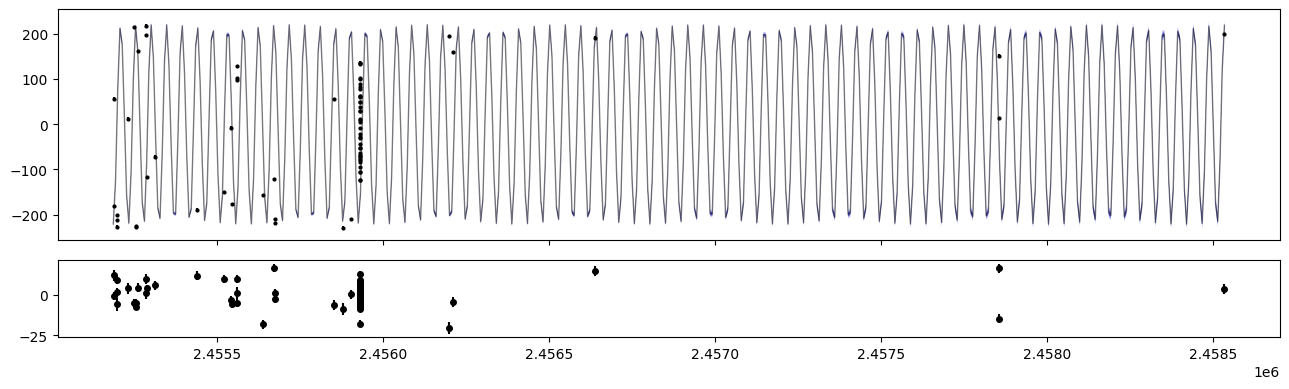

In [27]:
lpf.plot_rv_vs_time('mcmc');

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:363: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


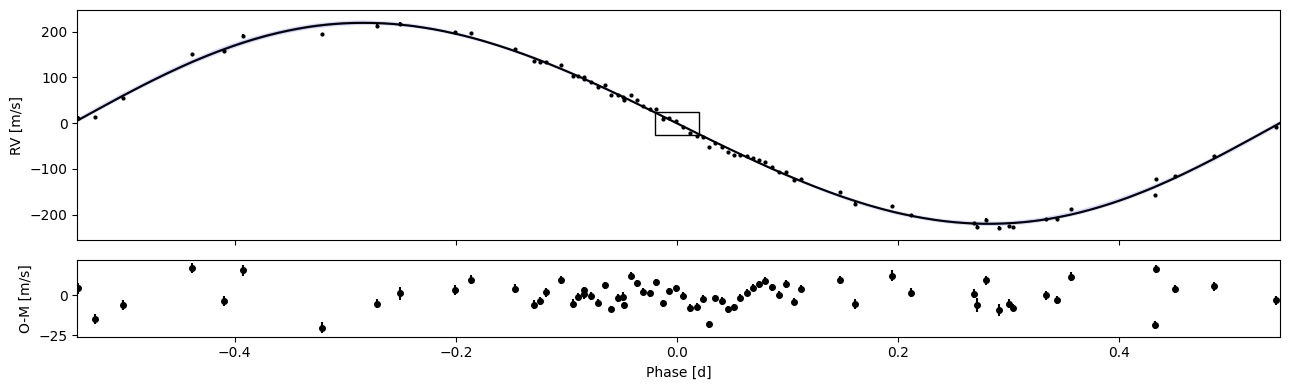

In [28]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
fig.axes[0].add_patch(Rectangle((-.02, -25), 0.04, 50, fill=False));

When we zoom a little bit, we can see that we're now actually plotting the probability density of the model. The black line corresponds to the median of the model posterior, and the two shades to the 68% and 95% central posterior limits.

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:363: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


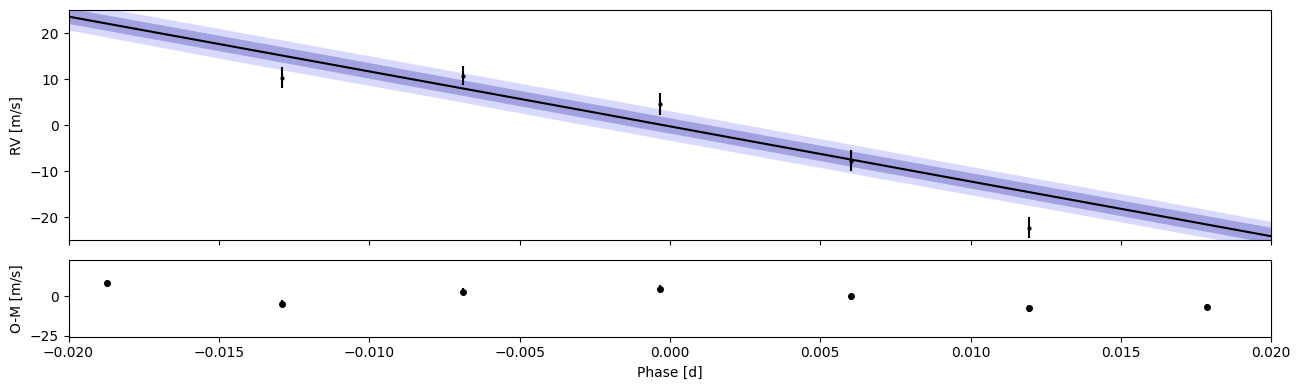

In [29]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
setp(fig.axes[0], xlim=(-0.02, 0.02), ylim=(-25,25));

### Plot the parameter posteriors

In [30]:
df = lpf.posterior_samples()
df

,tc_1,p_1,secw_1,sesw_1,rv_shift_0,rv_err_0,rv_k_1,rv_slope
0,0.000004,1.091424,-0.076906,-0.143655,12.395511,7.193721,216.929965,0.000849
1,0.000008,1.091424,-0.040797,-0.155176,12.495772,7.328790,218.744677,0.002129
2,0.000002,1.091424,-0.063308,-0.147770,12.684559,7.441551,218.293298,0.003199
3,-0.000019,1.091424,0.058979,-0.172740,13.752012,8.442221,222.917709,0.003150
4,-0.000010,1.091424,-0.028102,-0.186229,14.131521,7.682333,222.892581,0.000094
...,...,...,...,...,...,...,...,...
9995,-0.000008,1.091424,-0.018278,-0.201395,13.182537,7.691829,220.374691,-0.000566
9996,-0.000009,1.091424,-0.029059,-0.203556,13.788997,7.383395,219.767215,-0.000377
9997,-0.000010,1.091424,-0.013492,-0.196953,13.894744,7.228078,219.152207,0.000434
9998,-0.000008,1.091424,-0.023775,-0.183133,12.726660,7.208582,216.639359,0.001116


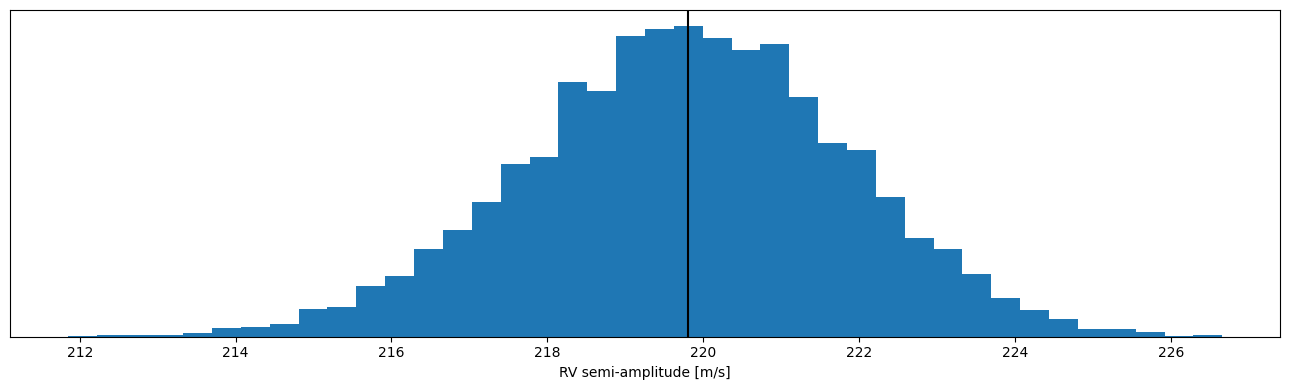

In [31]:
fig, ax = subplots()
ax.hist(df.rv_k_1, bins=40)
ax.axvline(median(df.rv_k_1), c='k')
setp(ax, xlabel='RV semi-amplitude [m/s]', yticks=[])
fig.tight_layout()

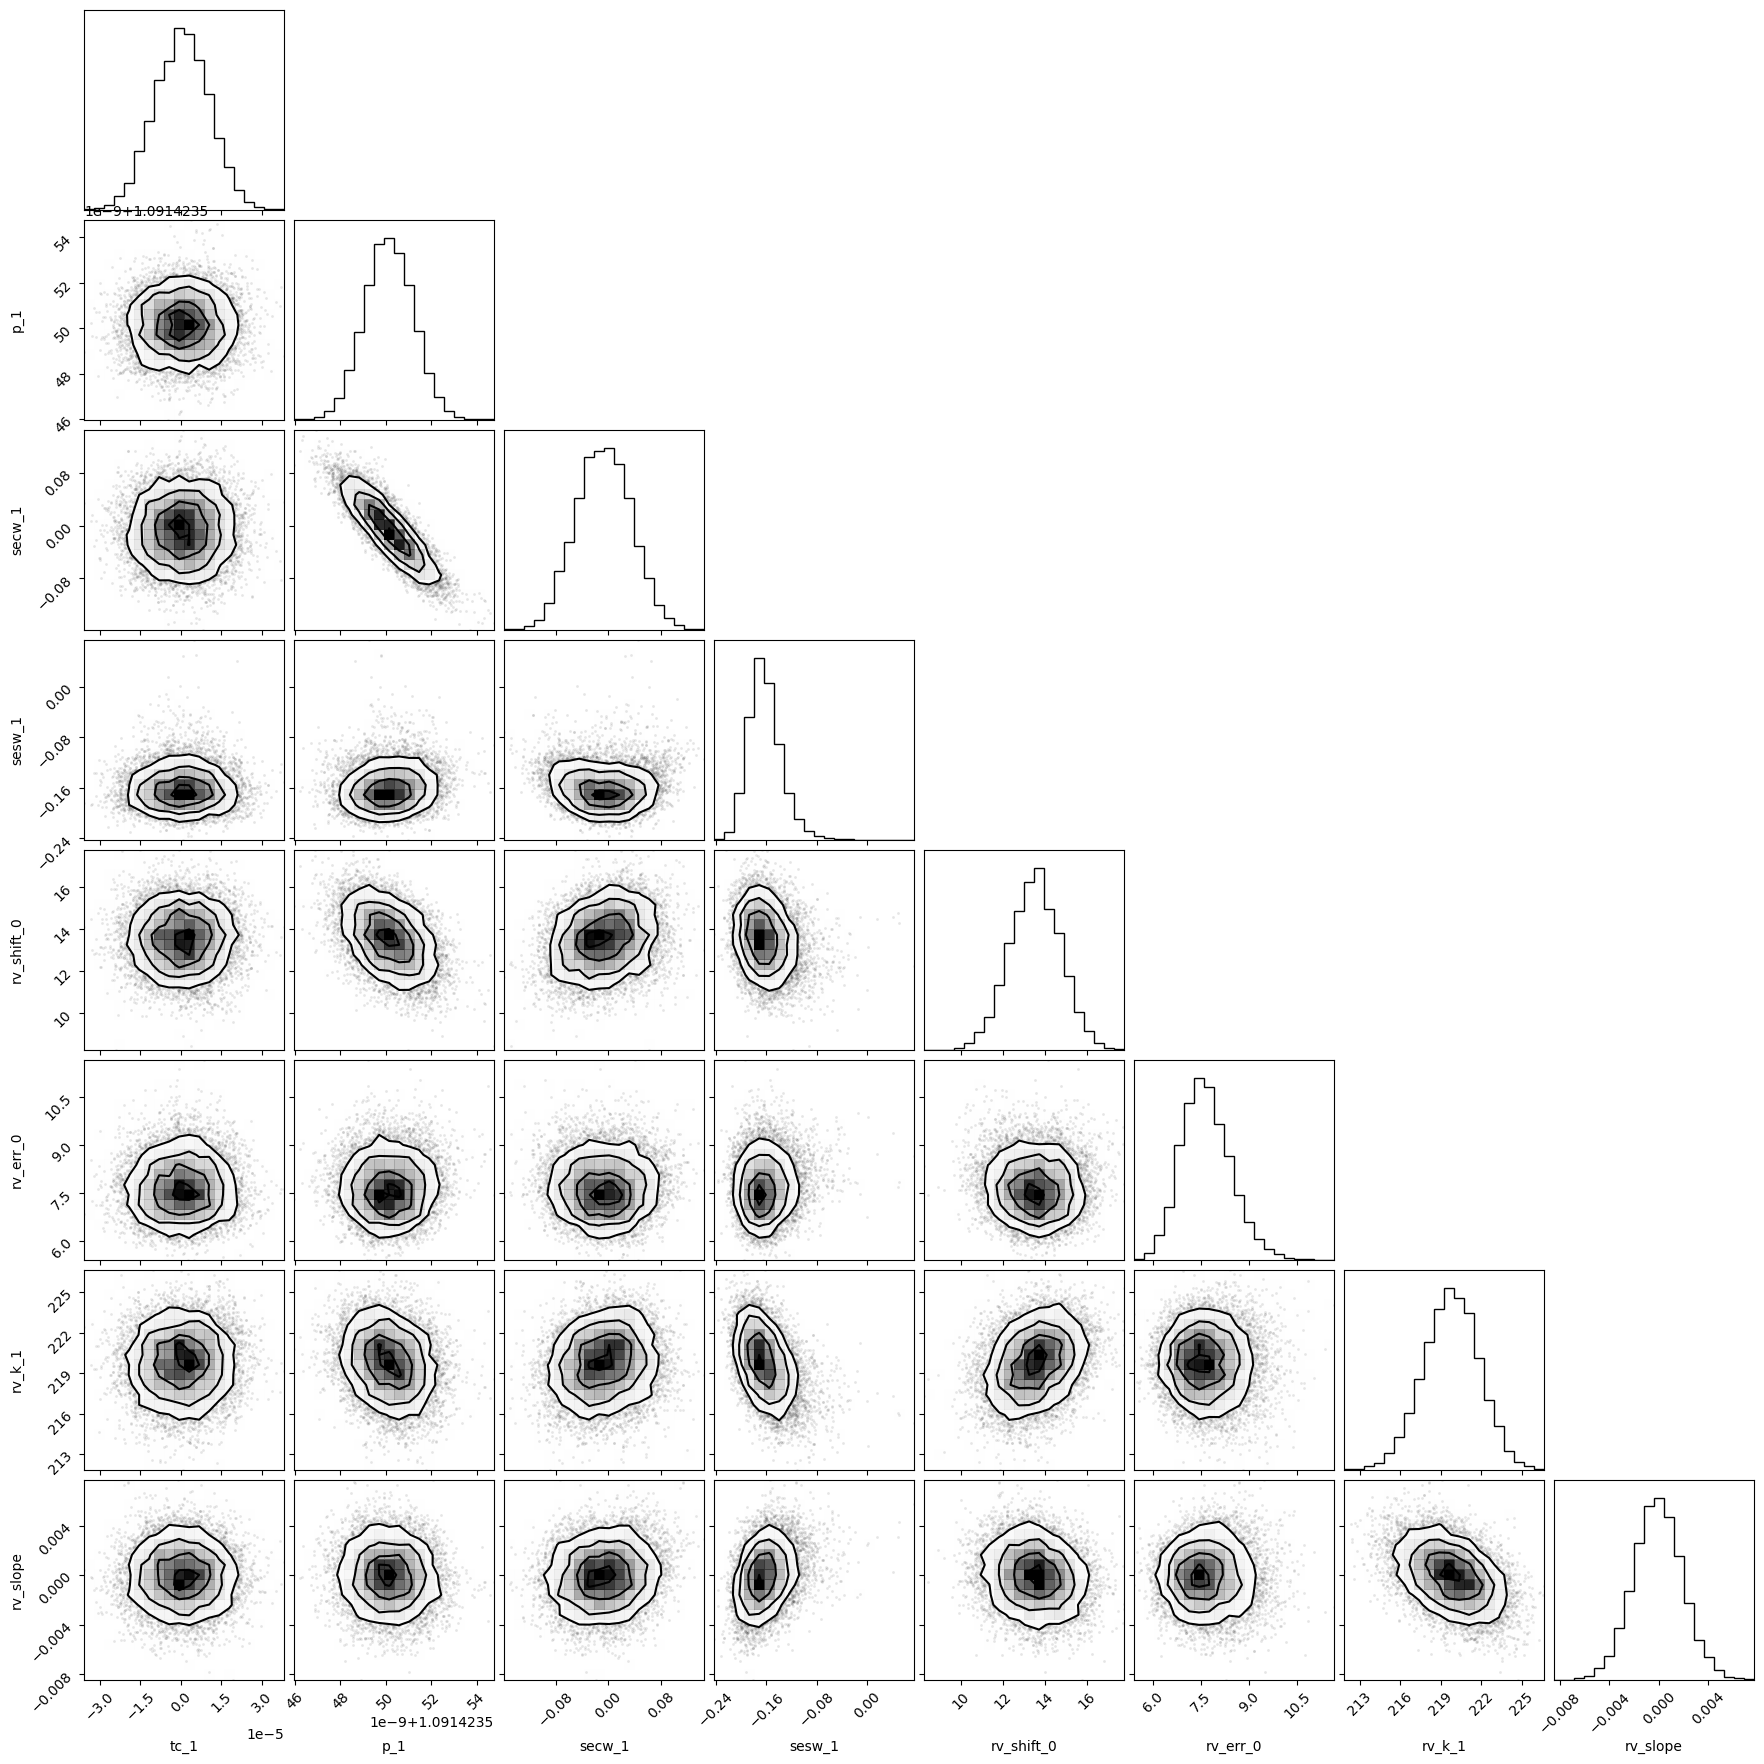

In [32]:
corner(df, labels=df.columns);

# Questions

1. What is the minimum mass $m$·$sin(i)$ of WASP-12b assuming $e = 0$
? You can derive this from the RV semi-amplitude (K), orbital period (p), and the host star mass.



RESOLUTION:
1. First, the constants are defined: Msun (Solar Mass), MJ (Jupiter mass), G (Gravitational constant).
2. Then the WASP-12 mass is defined and the planet mass too. 
3. The best period is used for the calculations. It is converted into seconds.
4. Using the formula $K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}} \frac{1}{(1-e^2)^{1/2}}$. In this case it is considered an eccentricity of e=0, then $M_\star + M_\mathrm{p} \approx M_\star$. 

5. The K value is recalculated, because the excentricity in the formula has changed. So the $K_{new} = K \cdot \frac{(1-e^2)^{1/2}}{(1-e'^2)^{1/2}}=K \cdot (1-e^2)^{1/2}$. 

6. For the original value of eccentricity, $e={secw_1^2+secsw_1^2}$. A new value of K is obtained. 

7. Finally, to calculate the minimum mass for the planet in this conditions, the new K value is used. The formula is: $m \sin i= K_{new}\cdot \frac{M_\star^{2/3}\cdot P^{1/3}}{(2 \pi G)^{1/3}}$ . 

8. The resultant minimun mass for the planet is: 1.3642 MJ.

In [47]:
#Resolution:
Msun =2E30 #Solar mass
MJ=1.9E27 # Jupiter mass
Mstar = 1.35*Msun #Mstar WASP-12
G=6.674E-11 #Gravitation Constant
P=best_period*86400 #Period in seg
Mp=1.43*MJ # WASP-12b mass
K= df.rv_k_1 #K value from the data
secw1 = df.secw_1 #secw_1 parameter
sesw1 = df.sesw_1 #secw_2 parameter
new_e = (secw1**2)+(sesw1**2) #New value from the excentricity
new_K = K*(1-(new_e)**2)**(1/2) #New value for K
MpsinI = new_K*((Mstar+Mp)**(2/3))*((P/(2*np.pi*G))**(1/3)) #The Mp sin i is recalculated with the new K.
MPmed=np.mean(MpsinI) #The mass planet average is calculated
print('Minimum mass m sin(i) of WASP-12b is', "{:.4f}".format(MPmed/MJ), 'Jupiter mass')


Minimum mass m sin(i) of WASP-12b is 1.3642 Jupiter mass


2. What would be the RV semi-amplitude of an Earth-mass planet orbiting WASP-12 with an orbital period of 365 days?

RESOLUTION:

1. The 365 days period is converted into seconds. The Earth-mass planet is used too. 
2. The excentricity is aproximately zero. I make this assumption. 
3. The semi-amplitude formula is used. 
4. The semi-amplitude of an Earth-mass planet, orbiting WASP-12 is 0.07294 m/s. 

In [41]:
#Resolution:
P2=365*86400 #Period in seg
Mp=5.97E24 # EarthMass planet. #Assume that sin(i) = 1. So Mp sin(i) = Mp
e = 0 # Assume that the excentricity is zero.
K = ((2*np.pi*G)/(P2))**(1/3)*(Mp)/(Mstar+Mp)**(2/3) #The semi-amplitude formula is used.
print('The RV semi-amplitude of an Earth-mass planet, orbiting WASP-12 is', "{:.5f}".format(K),'m/s')

The RV semi-amplitude of an Earth-mass planet, orbiting WASP-12 is 0.07294 m/s


3. We parameterise the model using ($\sqrt(e) sin (\omega)$, $\sqrt (e) cos \omega$)instead of ($e$, $ω$)
, 
). This parameterisation is more efficient to sample with an MCMC sampler, but means we need to take some extra steps to get the eccentricity and argument of periastron samples. Write below the equations you need to use to map the sampling parameters to $e$, $ω$?

4. Derive $e$ and $ω$ from the MCMC samples and plot their histograms.

RESOLUTION:

To obtain the eccentricity, we just need to apply $e=secw_1^2+sesw_1^2$, and from that, we can calculate $\omega$ with $\omega=arccos\left( \frac{secw_1}{\sqrt{e}}\right)=arccos\left( \frac{secw_1}{^2\sqrt{secw_1^2+sesw_1^2}}\right)$.

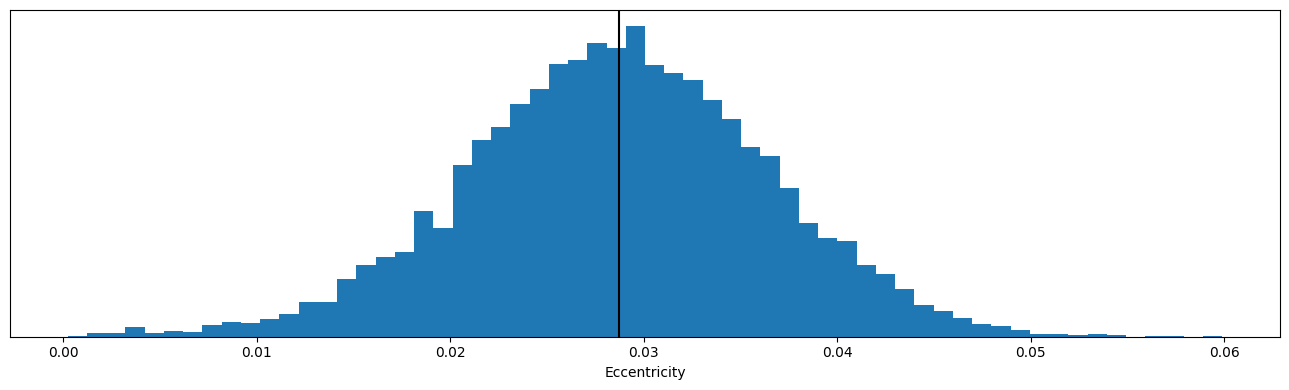

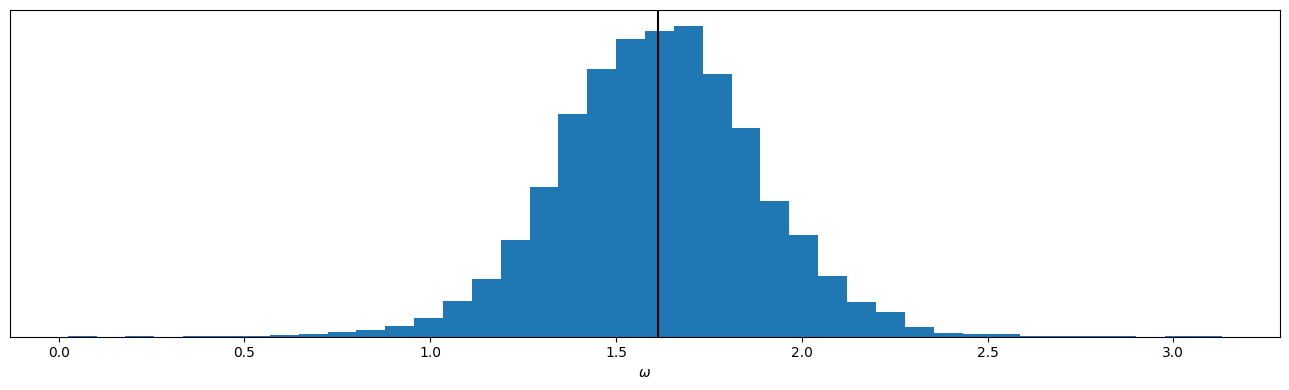

In [48]:
e= new_e #The excentricity is used.
#Plot:
fig, ax = subplots()
ax.hist(e, bins=60) # The bins are defined for the histogram.
ax.axvline(median(e), c='k') #The excentriciy median is calculated
setp(ax, xlabel='Eccentricity', yticks=[])
fig.tight_layout()

#The periastron is calculated:
w=np.arccos(secw1/np.sqrt(e))
fig, ax = subplots()
ax.hist(w, bins=60) #The bins are defined for the histogram
ax.axvline(median(w), c='k') #The periastron median is calculated
setp(ax, xlabel=r'$\omega$', yticks=[])
fig.tight_layout()